In [12]:
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import PIL

import tensorflow as tf
import scipy.misc
import numpy as np
import random

In [2]:
CELEB_PATH = '/home/jakub/Studia/mgr/ml-compression/data/img_align_celeba'

In [5]:
all_celebs = glob(CELEB_PATH + '/*')

In [6]:
len(all_celebs)

202599

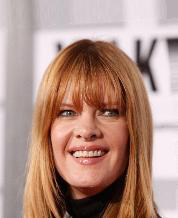

In [9]:
img = Image.open(all_celebs[0])
img

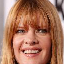

In [17]:
img = Image.open(all_celebs[0])

def img_to_np(img):
    np_img = np.array(img)
    return normalize_colors(np_img)

def normalize_colors(x):
    return x / 255.0

def celeba_crop(celeb_img, crop_size):
    crop_box = (25, 50, 25 + 2 * crop_size, 50 + 2 * crop_size)
    cropped = celeb_img.crop(crop_box)
    resized = cropped.resize((crop_size, crop_size), PIL.Image.NEAREST)
    return img_to_np(resized), resized

_, res = celeba_crop(img, 64)
res

In [21]:
celebs = []
for i in range(0, 10):
    img = Image.open(all_celebs[i])
    _, r = celeba_crop(img, 64)
    celebs.append(img.size)
celebs

[(178, 218),
 (178, 218),
 (178, 218),
 (178, 218),
 (178, 218),
 (178, 218),
 (178, 218),
 (178, 218),
 (178, 218),
 (178, 218)]